In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import os
import glob
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, losses, metrics, regularizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K 

/home/duke/.conda/envs/heads/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [6]:
from keras.datasets import mnist

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

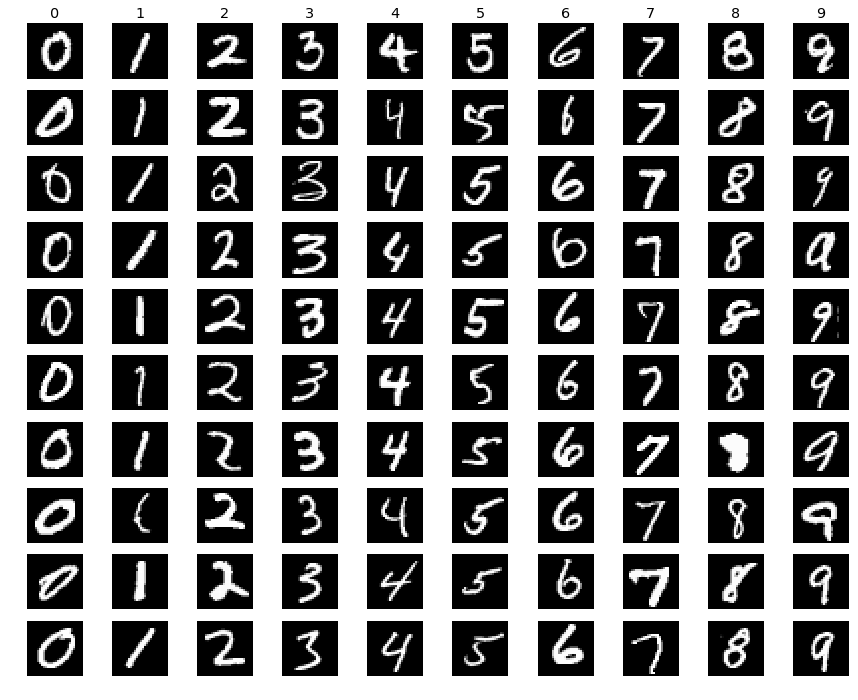

In [9]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

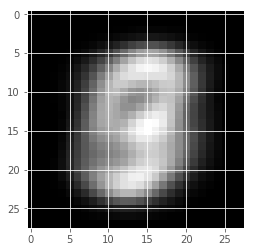

In [10]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8'), cmap='gray') # визуализируем полученное среднее
plt.show()

In [11]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

In [24]:
def build_encoder():
    img_input = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(32, kernel_size=4, strides=2, padding='same')(img_input)
    x = layers.ELU()(x)
    x = layers.Conv2D(32, kernel_size=4, strides=1, padding='same')(x)
    x = layers.ELU()(x)
    
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2D(64, kernel_size=4, strides=1, padding='same')(x)
    x = layers.ELU()(x)
    
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2D(128, kernel_size=4, strides=1, padding='same')(x)
    x = layers.ELU()(x)
    
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.ELU()(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    
    output = layers.GlobalAvgPool2D()(x)
    
    return models.Model(img_input, output, 
                        name='encoder')

In [25]:
def build_siamese():
    img_input = layers.Input(shape=(28, 28, 1))
    img_input_pair = layers.Input(shape=(28, 28, 1))
    encoder = build_encoder()
    
    embedding = encoder(img_input)
    embedding_pair = encoder(img_input_pair)
    
    output = layers.dot([embedding, embedding_pair], axes=-1, normalize=True)
    
    
    return models.Model([img_input, img_input_pair], output, 
                        name='siamese')

In [26]:
K.clear_session()
model = build_siamese()

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 128)          787616      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1)            0           encoder[1][0]                    
          

Тренировочный цикл

In [28]:
def generate_batch(data, labels, batch_size):
    indexes = np.arange(len(data))
    
    while True:
        batch_obj = []
        batch_pair_obj = []
        batch_label = []
        for _ in range(batch_size // 2):
            class_index = np.random.choice(labels, 1, replace=False)

            class_objects_indexes = indexes[labels == class_index]
            object_index, positive_index = np.random.choice(class_objects_indexes, 2, replace=False)
            

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[positive_index])
            batch_label.append(1)

            other_objects_indexes = indexes[labels != class_index]
            negative_index = np.random.choice(other_objects_indexes, 1, replace=False)

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[negative_index[0]])
            batch_label.append(-1)

        yield [np.expand_dims(batch_obj, -1), np.expand_dims(batch_pair_obj, -1)], np.array(batch_label)
    

In [29]:
generator = generate_batch(x_train, y_train, 128)
generator_val = generate_batch(x_val, y_val, 128)

In [30]:
# for item in generator:
#     print (item[0][1].shape)

In [31]:
adam = optimizers.Adam(lr=0.0001,amsgrad=True)
model.compile('adam', 'mse', metrics=['acc'])

In [32]:
model.fit_generator(generator=generator, 
                    steps_per_epoch= 1024, 
                    epochs=256, 
                    validation_steps= 32, 
                    validation_data=generator_val, 
                    callbacks= [ReduceLROnPlateau(patience=6, monitor='loss', epsilon=0.01, verbose=1)])

Epoch 1/256
1024/1024 [==============================] - 133s 130ms/step - loss: 0.4983 - acc: 0.4834 - val_loss: 0.4205 - val_acc: 0.4922
Epoch 2/256
1024/1024 [==============================] - 134s 131ms/step - loss: 0.4115 - acc: 0.4917 - val_loss: 0.4108 - val_acc: 0.4900
Epoch 3/256
1024/1024 [==============================] - 134s 131ms/step - loss: 0.4072 - acc: 0.4939 - val_loss: 0.4094 - val_acc: 0.4907
Epoch 4/256
1024/1024 [==============================] - 136s 133ms/step - loss: 0.4043 - acc: 0.4954 - val_loss: 0.4118 - val_acc: 0.4910
Epoch 5/256
1024/1024 [==============================] - 134s 130ms/step - loss: 0.4039 - acc: 0.4960 - val_loss: 0.4059 - val_acc: 0.4932
Epoch 6/256
1024/1024 [==============================] - 143s 140ms/step - loss: 0.4026 - acc: 0.4969 - val_loss: 0.4129 - val_acc: 0.4905
Epoch 7/256
1024/1024 [==============================] - 137s 134ms/step - loss: 0.4002 - acc: 0.4976 - val_loss: 0.4185 - val_acc: 0.4885
Epoch 8/256
1024/1024 [====

KeyboardInterrupt: 

In [72]:
def retrieve(index):
    request = x_test[index]
    data = np.expand_dims(x_test, -1)
    
    scores = model.predict([data, np.array([data[index]] * len(data))], batch_size=128)
    scores = np.squeeze(scores)
    scores[index] = -100
    
    sort = np.argsort(scores * -1)
    
#     return sort
    
    fig = plt.figure()
    a=fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x_test[index] + mean_image, cmap='gray')
    a.set_title('Request')
    a=fig.add_subplot(1,3,2)
    imgplot = plt.imshow(x_test[sort[0]] + mean_image, cmap='gray')
    a.set_title(f'Result. Label {y_test[sort[0]]}')
    a=fig.add_subplot(1,3,3)
    imgplot = plt.imshow(x_test[sort[1]] + mean_image, cmap='gray')
    a.set_title(f'Result. Label {y_test[sort[1]]}')
    plt.show()


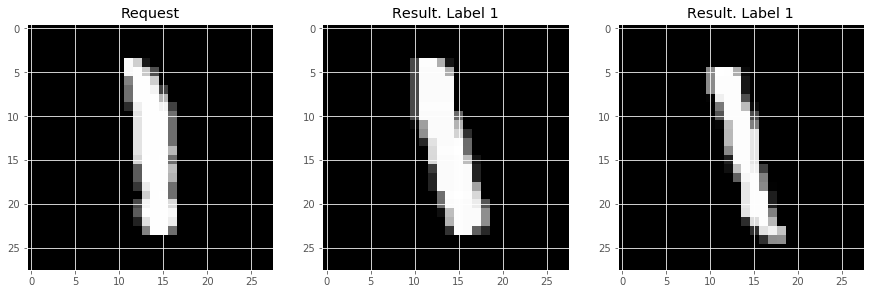

In [74]:
a = retrieve(777)